In [6]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torch.optim as optim
import torch.nn as nn
import pandas as pd
import numpy as np
import os
import cv2
from torchvision import models
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [7]:
# 超参数设置
IMG_SIZE = 224
BATCH_SIZE = 64
NUM_CLASSES = 7
EPOCHS = 30
LEARNING_RATE = 0.001

# 初始化记录容器
train_loss_history = []
val_loss_history = []
val_acc_history = []

# 设备配置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 数据文件夹路径
train_dir = "./train"
test_dir = "./test"

In [8]:
# 分割train和validation
base_transforms = transforms.Compose([
    transforms.Resize((224, 224)),              
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

addition_transforms = transforms.Compose([
    transforms.Resize((224, 224)),                # 调整为 224x224 像素 （因为后面使用ResNet）
    transforms.RandomHorizontalFlip(p=0.5),           # 随机水平翻转
    transforms.RandomRotation(10),              # 随机旋转
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  # 随机平移
    transforms.ToTensor(),                      # 转换为张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # 使用预训练好的 ResNet 模型时，均值和标准差通常是根据预训练所使用的数据集（例如 ImageNet）预先计算好的。
])

full_train_dataset = ImageFolder(root=train_dir, transform=base_transforms)
train_size = int(0.8 * len(full_train_dataset))  # 80% 训练集
val_size = len(full_train_dataset) - train_size  # 20% 验证集
train_dataset, validation_dataset = random_split(full_train_dataset, [train_size, val_size])

train_dataset.dataset.transform = addition_transforms

# 创建DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 检查数据集是否正确加载
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(validation_dataset)}")

Number of training samples: 9816
Number of validation samples: 2455


In [9]:
from timm import create_model

# 创建 Swin Transformer 模型
model = create_model("swin_tiny_patch4_window7_224", pretrained=True, num_classes=7).to(device)

# 损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)  # 余弦退火学习率调度器

In [10]:
# train model
num_epochs = EPOCHS
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
all_labels = []
all_predictions = []
best_acc = 0
best_epoch = 0
patience = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # 使用 tqdm 显示训练进度
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

    # 调整学习率
    scheduler.step()

    # 评估模型
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch+1}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # 检查是否需要早停
    if val_accuracy > best_acc:
        best_acc = val_accuracy
        best_epoch = epoch + 1
        no_improve_count = 0  # 重置未提升计数
        torch.save(model, 'swin.pt')
    else:
        no_improve_count += 1  # 记录未提升次数

        # **如果超过 patience 轮未提升，则提前终止训练**
    if no_improve_count >= patience:
        print(f"early stopping triggered....at epoch: {best_epoch}")
        print(f"best val_accuracy: {best_acc}")
        break

print('Finished Training')

Epoch 1/30: 100%|██████████| 154/154 [04:53<00:00,  1.90s/it]


Epoch 1, Train Loss: 1.1328, Train Accuracy: 58.20%
Epoch 1, Val Loss: 0.8241, Val Accuracy: 69.98%


Epoch 2/30: 100%|██████████| 154/154 [04:48<00:00,  1.87s/it]


Epoch 2, Train Loss: 0.7247, Train Accuracy: 74.10%
Epoch 2, Val Loss: 0.6491, Val Accuracy: 76.78%


Epoch 3/30: 100%|██████████| 154/154 [04:48<00:00,  1.87s/it]


Epoch 3, Train Loss: 0.5789, Train Accuracy: 79.10%
Epoch 3, Val Loss: 0.6189, Val Accuracy: 78.90%


Epoch 4/30: 100%|██████████| 154/154 [04:46<00:00,  1.86s/it]


Epoch 4, Train Loss: 0.4789, Train Accuracy: 82.76%
Epoch 4, Val Loss: 0.5738, Val Accuracy: 79.84%


Epoch 5/30: 100%|██████████| 154/154 [04:47<00:00,  1.87s/it]


Epoch 5, Train Loss: 0.4133, Train Accuracy: 85.50%
Epoch 5, Val Loss: 0.5369, Val Accuracy: 82.57%


Epoch 6/30: 100%|██████████| 154/154 [04:48<00:00,  1.87s/it]


Epoch 6, Train Loss: 0.3306, Train Accuracy: 88.00%
Epoch 6, Val Loss: 0.6125, Val Accuracy: 80.12%


Epoch 7/30: 100%|██████████| 154/154 [04:50<00:00,  1.89s/it]


Epoch 7, Train Loss: 0.2640, Train Accuracy: 90.50%
Epoch 7, Val Loss: 0.5780, Val Accuracy: 81.02%


Epoch 8/30: 100%|██████████| 154/154 [04:51<00:00,  1.89s/it]


Epoch 8, Train Loss: 0.2268, Train Accuracy: 91.98%
Epoch 8, Val Loss: 0.6126, Val Accuracy: 82.16%


Epoch 9/30: 100%|██████████| 154/154 [04:49<00:00,  1.88s/it]


Epoch 9, Train Loss: 0.1953, Train Accuracy: 92.88%
Epoch 9, Val Loss: 0.6578, Val Accuracy: 82.12%


Epoch 10/30: 100%|██████████| 154/154 [04:53<00:00,  1.91s/it]


Epoch 10, Train Loss: 0.1600, Train Accuracy: 94.41%
Epoch 10, Val Loss: 0.6633, Val Accuracy: 82.32%
early stopping triggered....at epoch: 5
best val_accuracy: 82.56619144602851
Finished Training


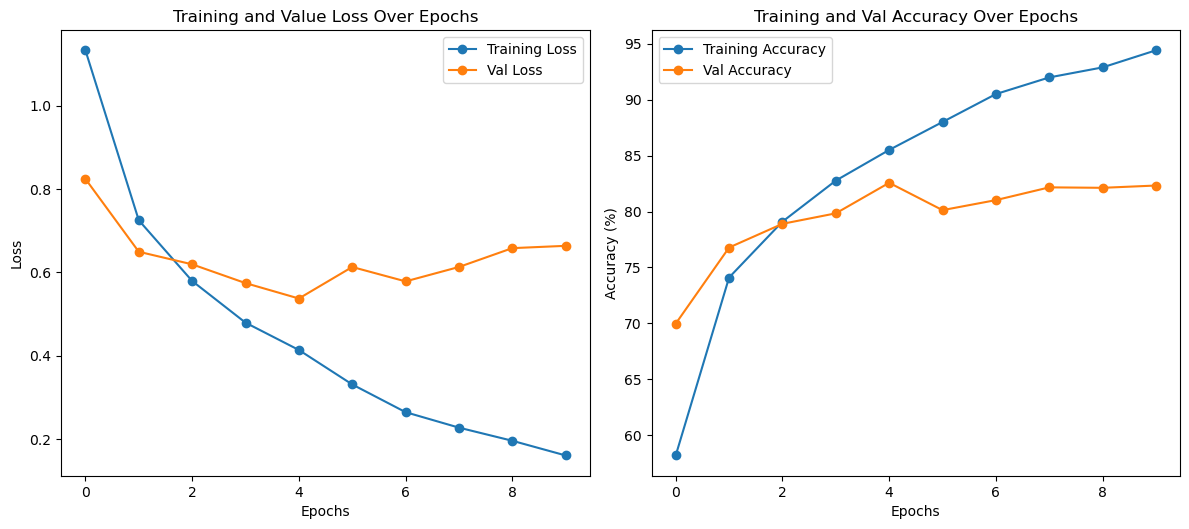

Precision: 0.7960
Recall: 0.7958
F1 Score (Weighted): 0.7938


In [11]:
import matplotlib.pyplot as plt
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
# Draw the accuracy and loss curves
epochs = range(len(train_losses))
plt.figure(figsize=(12, 10))

# Plotting training and val loss curves
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, 'o-', label='Training Loss')
plt.plot(epochs, val_losses, 'o-', label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Value Loss Over Epochs')
plt.legend()

# Plot training and val accuracy curves
plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies, 'o-', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'o-', label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Val Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Calculating F1-score, Precision and Recall
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
f1 = f1_score(all_labels, all_predictions, average='weighted')
print(f'F1 Score (Weighted): {f1:.4f}')

In [15]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.optim as optim
import torch.nn as nn
import pandas as pd
import numpy as np
import os
import cv2
from torchvision import models
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# 确保你的设备是 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

BATCH_SIZE = 64

test_dir = "./test"

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),              
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = ImageFolder(root=test_dir, transform=test_transforms)

test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Number of test samples: {len(test_dataset)}")

Using device: cuda
Number of test samples: 3068


C:\Users\HE\AppData\Local\Temp\ipykernel_14396\299710165.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("swin.pt")


Test Accuracy: 82.99%
Confusion Matrix:
 [[ 120    7    4    6   10    3   12]
 [  13   67    2   16   37   16    9]
 [   3    2   35    4    4    7   19]
 [   9   10    0 1097   44   10   15]
 [   5   12    0   33  565   41   24]
 [   6   13    1   21   58  373    6]
 [   7    3    5    3   17    5  289]]


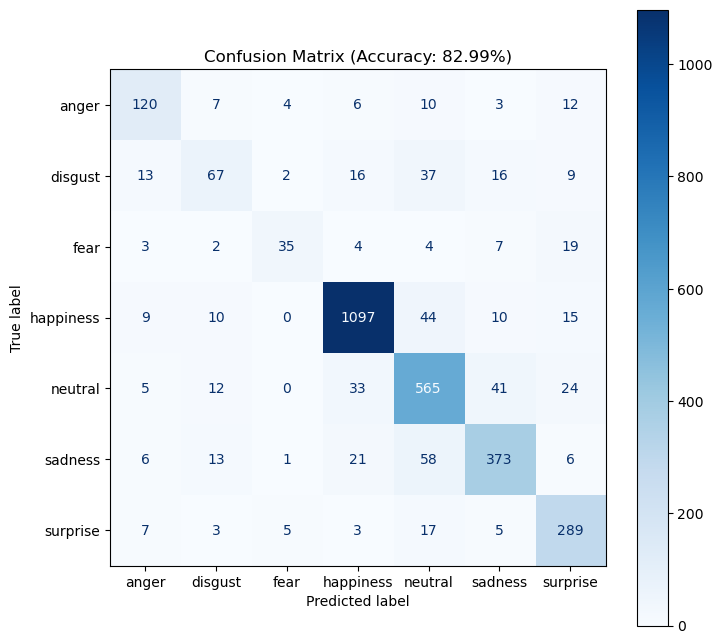

In [17]:
# 定义模型结构（与保存权重时一致）
model = torch.load("swin.pt")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()  # 切换到评估模式

# 初始化真实标签和预测标签
all_labels = []
all_preds = []

# 模型测试并记录标签
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# 计算准确率
accuracy = correct / total * 100
print(f"Test Accuracy: {accuracy:.2f}%")

# 计算混淆矩阵
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

# 绘制混淆矩阵
labels = test_dataset.classes  # 获取类别名称
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
plt.title(f"Confusion Matrix (Accuracy: {accuracy:.2f}%)")
plt.show()

| Emotion   | F1-Score |
|-----------|----------|
| anger     | 73.8%    |
| disgust   | 48.7%    |
| fear      | 57.9%    |
| happiness | 92.8%    |
| neutral   | 79.8%    |
| sadness   | 80.0%    |
| surprise  | 82.2%    |